# Параллельные вычисления (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

## Задачи для совместного разбора

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя пул процессов.

In [20]:
import multiprocessing

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [31]:
%%file f_queue.py
def count_a_queue(file_name, queue):
    with open(file_name, 'r') as fp:
        text = fp.read()
    a = text.count('a')
    print(f'{file_name} => {a}')
    queue.put(a)

Overwriting f_queue.py


In [22]:
%%time
a = []
for file in files:
    a.append(count_a(file))
sum(a)

xaa.txt => 2525754
xab.txt => 2530031
xac.txt => 2525324
xad.txt => 1417163
CPU times: total: 1.47 s
Wall time: 1.71 s


8998272

In [32]:
from f_queue import count_a_queue

In [24]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    r = pool.map(count_a, files)
sum(r)

CPU times: total: 15.6 ms
Wall time: 356 ms


8998272

In [25]:
r

[2525754, 2530031, 2525324, 1417163]

2. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя процессы и очереди.

In [33]:
%%time
# 0) хранилище
queue = multiprocessing.Queue()
# 1) создать процесс

processes = []
for file in files:
    p = multiprocessing.Process(target=count_a_queue, args=(file, queue))
    p.start()
    processes.append(p)
    
# 2) ждем завершения процессов
for p in processes:
    p.join()
# мы уверены, что все процессы завершились

# 3) забираем значения
res = []
while len(res) < len(files):
    if not queue.empty():
        r = queue.get()
        res.append(r)
sum(res)

# 2(4)) ждем завершения процессов
# for p in processes:
#     p.join()

CPU times: total: 0 ns
Wall time: 352 ms


8998272

## Лабораторная работа 5

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

In [1]:
import multiprocessing
import pandas as pd

<p class="task" id="1"></p>

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок). 

При создании файлов выводите на экран сообщения следующего вида:
`file: <название файла> #rows: <кол-во строк в этом файле>`

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [6]:
for i,chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=8_000_000)):
    chunk.to_csv(f'tag_nsteps_{i}.csv', index=False)
    print(f'file: tag_nsteps_{i}.csv #rows: {chunk.shape[0]}')

file: tag_nsteps_0.csv #rows: 8000000
file: tag_nsteps_1.csv #rows: 8000000
file: tag_nsteps_2.csv #rows: 8000000
file: tag_nsteps_3.csv #rows: 8000000
file: tag_nsteps_4.csv #rows: 8000000
file: tag_nsteps_5.csv #rows: 8000000
file: tag_nsteps_6.csv #rows: 8000000
file: tag_nsteps_7.csv #rows: 8000000
file: tag_nsteps_8.csv #rows: 6695585


<p class="task" id="2"></p>

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [2]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    dic = df.groupby('tags').agg(
        sum=('n_steps', 'sum'), count=('n_steps', 'count')
    ).to_dict('index')
    return dic    

In [3]:
lst = []
for i in range(9):
    lst.append(get_tag_sum_count_from_file(f'tag_nsteps_{i}.csv'))

In [4]:
for i in range(9):
    print(lst[i]['30-minutes-or-less'])

{'sum': 314736, 'count': 41099}
{'sum': 314582, 'count': 41361}
{'sum': 319951, 'count': 41923}
{'sum': 311806, 'count': 41069}
{'sum': 313895, 'count': 41095}
{'sum': 315528, 'count': 41448}
{'sum': 315000, 'count': 41544}
{'sum': 313347, 'count': 41346}
{'sum': 264360, 'count': 34897}


<p class="task" id="3"></p>

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [5]:
def agg_results(tag_sum_count_list: list) -> dict:
    import copy
    res = copy.deepcopy(tag_sum_count_list[0])
    for dct in tag_sum_count_list[1:]:
        for k, v in dct.items():
            agg_dct = res.get(k, {'sum': 0, 'count': 0})
            agg_dct['sum'] += v['sum']
            agg_dct['count'] += v['count']
            res[k] = agg_dct
    return res

agg = agg_results(lst)
agg['30-minutes-or-less']

{'sum': 2783205, 'count': 365782}

<p class="task" id="4"></p>

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре. Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла, можно пренебречь.

In [6]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    res = {}
    for k, v in tag_sum_count.items():
        res[k] = v['sum']/v['count']
    return res
get_tag_mean_n_steps(agg)['30-minutes-or-less']

7.608917333275011

In [7]:
%%time
files = [f'tag_nsteps_{i}.csv' for i in range(9)]
lst = []
for file in files:
    lst.append(get_tag_sum_count_from_file(file))
agg = agg_results(lst)
get_tag_mean_n_steps(agg)

CPU times: total: 14.4 s
Wall time: 22.9 s


{'1-day-or-more': 4.4520971258275495,
 '15-minutes-or-less': 4.986317967093519,
 '3-steps-or-less': 4.721988429642155,
 '30-minutes-or-less': 7.608917333275011,
 '4-hours-or-less': 10.084881902287728,
 '5-ingredients-or-less': 5.330010645504694,
 '60-minutes-or-less': 9.41942843691575,
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': 3.507963863489171,
 'a1-sauce': 3.522007764229865,
 'african': 4.353821369343757,
 'american': 7.5697864618088895,
 'amish-mennonite': 3.5625054532763283,
 'angolan': 3.484635752747986,
 'appetizers': 6.230973632213668,
 'apples': 4.862489082969432,
 'april-fools-day': 3.5105071292404766,
 'argentine': 3.5745268882845886,
 'artichoke': 3.497125083509479,
 'asian': 6.454297045484734,
 'asparagus': 4.07156120698355,
 'australian': 4.218087196542041,
 'austrian': 3.5707076272120237,
 'avocado': 3.5277872223745543,
 'bacon': 4.109118786153065,
 'baja': 3.5381549163584167,
 'baked-beans': 3.487642776033665,
 'baking': 3.6360772170674402

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [7]:
%%file get_tsc_file.py
import pandas as pd
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    dic = df.groupby('tags').agg(
        sum=('n_steps', 'sum'), count=('n_steps', 'count')
    ).to_dict('index')
    return dic

Overwriting get_tsc_file.py


In [8]:
from get_tsc_file import get_tag_sum_count_from_file

In [15]:
%%time
with multiprocessing.Pool(processes=9) as pool:
    r = pool.map(get_tag_sum_count_from_file, files)
    
    agg = agg_results(r)
    res = get_tag_mean_n_steps(agg)
    print(res['30-minutes-or-less'])

7.608917333275011
CPU times: total: 62.5 ms
Wall time: 5.42 s


<p class="task" id="6"></p>

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [9]:
%%file get_tsc_q_file.py
import pandas as pd
def get_tag_sum_count_from_file_q(file, queue) -> dict:
    df = pd.read_csv(file)
    dic = df.groupby('tags').agg(
        sum=('n_steps', 'sum'), count=('n_steps', 'count')
    ).to_dict('index')
    queue.put(dic)    

Overwriting get_tsc_q_file.py


In [10]:
from get_tsc_q_file import get_tag_sum_count_from_file_q

In [11]:
files = [f'tag_nsteps_{i}.csv' for i in range(9)]

In [12]:
%%time
queue = multiprocessing.Queue()

processes = []
for file in files:
    p = multiprocessing.Process(target=get_tag_sum_count_from_file_q, args=(file, queue))
    p.start()
    processes.append(p)

res = []
while len(res) < len(files):
    if not queue.empty():
        r = queue.get()
        res.append(r)
        
for p in processes:
    p.join()


agg = agg_results(res)
ans = get_tag_mean_n_steps(agg)
ans['30-minutes-or-less']

CPU times: total: 5.53 s
Wall time: 6.3 s


7.608917333275011

<p class="task" id="7"></p>

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$ (воспользуйтесь функцией `multiprocessing.cpu_count`). Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [14]:
K = multiprocessing.cpu_count()
K

8

In [15]:
# K/2
for i,chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=18_000_000)):
    chunk.to_csv(f'tag_nsteps4_{i}.csv', index=False)
    print(f'file: tag_nsteps4_{i}.csv #rows: {chunk.shape[0]}')

file: tag_nsteps4_0.csv #rows: 18000000
file: tag_nsteps4_1.csv #rows: 18000000
file: tag_nsteps4_2.csv #rows: 18000000
file: tag_nsteps4_3.csv #rows: 16695585


In [19]:
files4 = [f'tag_nsteps4_{i}.csv' for i in range(4)]

In [20]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    r = pool.map(get_tag_sum_count_from_file, files4)

    agg = agg_results(r)
    res = get_tag_mean_n_steps(agg)
    print(res['30-minutes-or-less'])

7.608917333275011
CPU times: total: 15.6 ms
Wall time: 7.22 s


In [21]:
# K
for i,chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=9_000_000)):
    chunk.to_csv(f'tag_nsteps8_{i}.csv', index=False)
    print(f'file: tag_nsteps8_{i}.csv #rows: {chunk.shape[0]}')

file: tag_nsteps8_0.csv #rows: 9000000
file: tag_nsteps8_1.csv #rows: 9000000
file: tag_nsteps8_2.csv #rows: 9000000
file: tag_nsteps8_3.csv #rows: 9000000
file: tag_nsteps8_4.csv #rows: 9000000
file: tag_nsteps8_5.csv #rows: 9000000
file: tag_nsteps8_6.csv #rows: 9000000
file: tag_nsteps8_7.csv #rows: 7695585


In [27]:
files8 = [f'tag_nsteps8_{i}.csv' for i in range(8)]

In [35]:
%%time
with multiprocessing.Pool(processes=8) as pool:
    r = pool.map(get_tag_sum_count_from_file, files8)

    agg = agg_results(r)
    res = get_tag_mean_n_steps(agg)
    print(res['30-minutes-or-less'])

7.608917333275011
CPU times: total: 46.9 ms
Wall time: 5.34 s


In [29]:
# 2K
for i,chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=4_500_000)):
    chunk.to_csv(f'tag_nsteps16_{i}.csv', index=False)
    print(f'file: tag_nsteps16_{i}.csv #rows: {chunk.shape[0]}')

file: tag_nsteps16_0.csv #rows: 4500000
file: tag_nsteps16_1.csv #rows: 4500000
file: tag_nsteps16_2.csv #rows: 4500000
file: tag_nsteps16_3.csv #rows: 4500000
file: tag_nsteps16_4.csv #rows: 4500000
file: tag_nsteps16_5.csv #rows: 4500000
file: tag_nsteps16_6.csv #rows: 4500000
file: tag_nsteps16_7.csv #rows: 4500000
file: tag_nsteps16_8.csv #rows: 4500000
file: tag_nsteps16_9.csv #rows: 4500000
file: tag_nsteps16_10.csv #rows: 4500000
file: tag_nsteps16_11.csv #rows: 4500000
file: tag_nsteps16_12.csv #rows: 4500000
file: tag_nsteps16_13.csv #rows: 4500000
file: tag_nsteps16_14.csv #rows: 4500000
file: tag_nsteps16_15.csv #rows: 3195585


In [30]:
files16 = [f'tag_nsteps16_{i}.csv' for i in range(16)]

In [31]:
%%time
with multiprocessing.Pool(processes=16) as pool:
    r = pool.map(get_tag_sum_count_from_file, files16)

    agg = agg_results(r)
    res = get_tag_mean_n_steps(agg)
    print(res['30-minutes-or-less'])

7.608917333275011
CPU times: total: 141 ms
Wall time: 6.51 s


In [32]:
import matplotlib.pyplot as plt

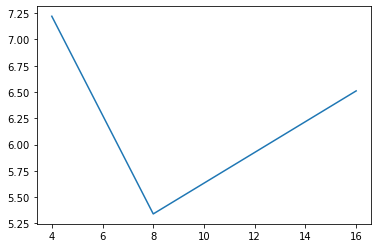

In [36]:
x = [4, 8, 16]
y = [7.22, 5.34, 6.51]
plt.plot(x, y);